## Used resources for Schunk development

### CAN resources 

* [How to use ros-canopen](https://answers.ros.org/question/233735/how-to-used-ros_canopen/)   
* [canopen_test_utils](https://github.com/ipa320/canopen_test_utils)     
* [schunk_lwa4p_canopen](https://github.com/jlarraez/schunk_lwa4p)    
* [ros_canopen overview](http://wiki.ros.org/ros_canopen)  
* [canopenchain_node_overview](http://wiki.ros.org/canopen_chain_node)   
* [CanOpenBUSLayer](http://wiki.ros.org/canopen_chain_node#Configuration)
* [CANOpen ROS package getting started](https://community.husarion.com/t/canopen-ros-package-getting-started/475/2) 

#### TODO: 
 - [ ] Add special CAN primer on github page

Very good presentation about rosbag api can be found [here](https://www.fer.unizg.hr/_download/repository/lec08-rosbag-ipython.pdf).

In [3]:
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd

## How to setup virtual environment? 

You can setup `virtualenv` quite easily by following instructions on following [link](https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/26/python-virtual-env/) 

### How to activate virtual environment? 

Run following command inside folder in which you have created virtual environment as follows: `source <virtualenv_name>/bin/activate` 

After that you can use `pip3 install <package_name>` to install neccessary python packages. 

## Read bag

In [4]:
bag_name = "servo_bag_0209.bag"

b = bagreader(bag_name)

[INFO]  Data folder servo_bag_0209 already exists. Not creating.


### Insert data into csv_files

In [5]:
csv_files = []
for topic in b.topics:
    #print(topic)
    data = b.message_by_topic(topic)
    csv_files.append(data)
    

In [6]:
print(csv_files)

['servo_bag_0209/lwa4p-joint_group_position_controller-command.csv', 'servo_bag_0209/lwa4p-joint_states.csv', 'servo_bag_0209/move_group-goal.csv', 'servo_bag_0209/pose_error.csv', 'servo_bag_0209/servo_server-delta_twist_cmds.csv', 'servo_bag_0209/servo_server-status.csv', 'servo_bag_0209/servo_server-target_pose.csv']


In [7]:
servo_joint_cmds = pd.read_csv(csv_files[0])
joint_states = pd.read_csv(csv_files[1])
move_group_goal = pd.read_csv(csv_files[2])
pose_error = pd.read_csv(csv_files[3])
delta_twist_cmds = pd.read_csv(csv_files[4])
servo_status = pd.read_csv(csv_files[5])
target_pose = pd.read_csv(csv_files[6])


### How to plot pandas dataframe with matpotlib? 

Instructions for plotting pandas dataframe with matplotlib can be found [here](https://pandas.pydata.org/pandas-docs/version/0.13/visualization.html)

More documentation about plotting matplolib can be found [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) 

In [8]:
#methods for exploring dataframe
#print(type(joint_states))
#print(joint_states)
#print(dir(joint_states))
#print(joint_states['position_0'])
#print(type(joint_states['position_0'])) # Just one column is Series which is quite suitable for plotting

In [9]:
#print(joint_group_position_ctl_cmd)
#print(dir(joint_group_position_ctl_cmd))

In [10]:
def get_series_by_key_from_df(dataframe, key):
    """
         dataframe: pandas dataframe that contains measurements 
         key: key by which we extract dataseries
    """
    series_list = []
    for column in dataframe.columns:
        if key in str(column): 
            series_list.append(dataframe["{}".format(column)])
    return series_list

def plot_series(time, series, scale_time=False):
    """
        time: pandas series for time 
        series: pandas series for measurement 
        scale_time: boolean for scaling time to 0-duration scale (if not use_sim_time active)
    """
    plt.figure()
    assert(len(time) == len(series)), "Please check your data lengths"        
    
    #if use_sim_time = False 
    if scale_time:
        time = [t - time[0] for t in time]
        
    plt.plot(time, series)
    plt.grid(color='0.95')
    plt.title('{}'.format(series.name))
    plt.show()  


def plot_multiple_series(time, series_list, series_names = None, config_dict = None, scale_time=False, save_fig=False, save_name=None):
    """
        time: pandas series for time 
        series_list: list containing pandas series
        series_names: list containing names for each series that's going to be plotted
        config_dict: dictionary containing config params
        scale_time: boolean for scaling time to 0-duration scale (if not use_sim_time active)
    
    """
    
    if config_dict: 
        title = config_dict['title']
        x_label = config_dict['x_label']
        y_label = config_dict['y_label']
        width, height = config_dict['w'], config_dict['h']
        use_legend = config_dict['use_legend']
        grid = config_dict['grid']
        f_size = config_dict['font_size']
        #ref_plot = True
        
    else:
        title="graph"
        x_label = "t"
        y_label = "data"
        width, height = 5, 5
        use_legend = False
        grid = False
        ref_plot = False
    
    # Create figure
    plt.figure(figsize=(width, height))
    # Check if len of time is same as len of series (plotting condition)
    for series in series_list:
        assert(len(time) == len(series)), "Please check one of your series from series list"
    
    # Scale time to secs if use_sim_time=False (e.g. real_robot)
    if scale_time:
        time = [t - time[0] for t in time]    
        
    # Plot series 
    # https://www.geeksforgeeks.org/matplotlib-pyplot-legend-in-python/
    if use_legend: 
        for series_name, series_value in zip(series_names, series_list):
            # Condition for setpoint plotting
            if "sp" in series_name:
                plt.plot(time, series_value, label=series_name, linestyle="-.")
            else:
                plt.plot(time, series_value, label=series_name)
    else:
        for series_value in series_list:
            if "sp" in series_name:
                plt.plot(time, series_value,label=series_name, linestyle="-.")
            else: 
                plt.plot(time, series_value, label=series_name)
    
    if grid: 
        plt.grid(color="grey")
    if use_legend: 
        plt.legend(loc ="best")
        
    plt.title(title, fontsize=round(1.2*f_size))
    plt.xlabel(x_label, fontsize=f_size)
    plt.ylabel(y_label, fontsize=f_size)    
        
    if save_fig: 
        plt.savefig("{}.jpg".format(save_name))
        
    plt.show()


    

### Plot joint cmd positions

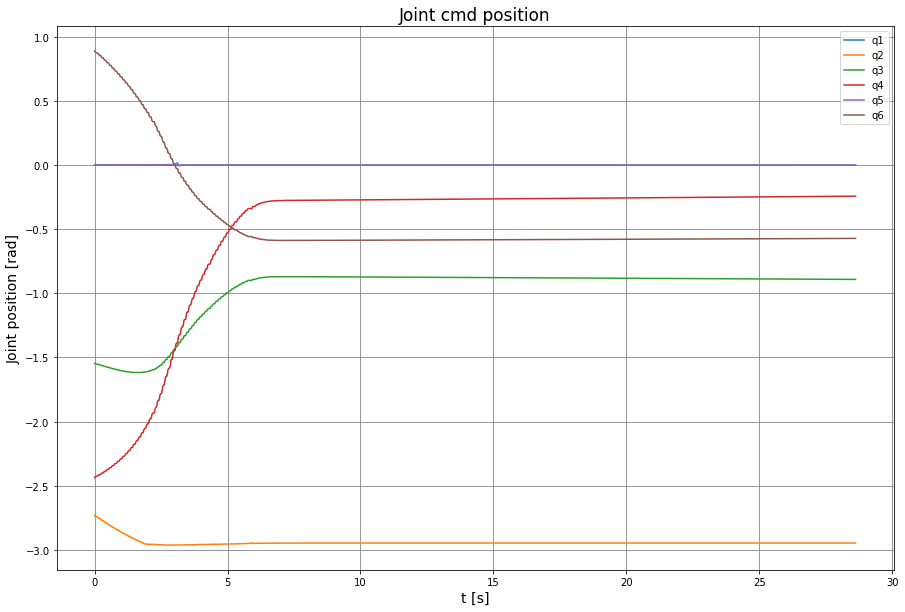

In [11]:
time_servo = servo_joint_cmds["Time"]
series_names = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6']
series_list = get_series_by_key_from_df(servo_joint_cmds, "data")

config_dict = {
               "title":"Joint cmd position", 
               "x_label":"t [s]",
               "y_label": "Joint position [rad]",
               "w": 15,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True                
              }

plot_multiple_series(time_servo, series_list, series_names, config_dict, scale_time=True)

### Plot joint states positions

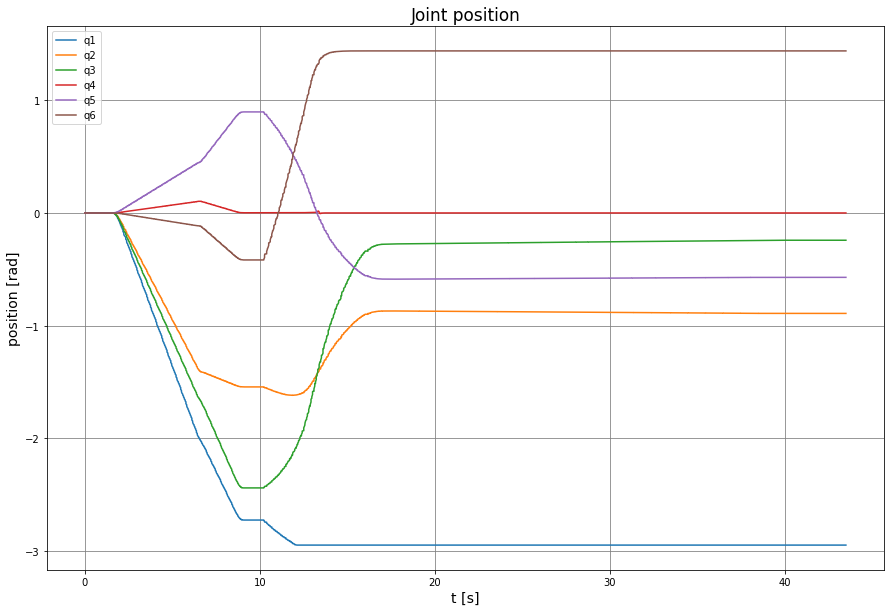

In [12]:
joint_states = pd.read_csv(csv_files[1])
time_full = joint_states['Time']
series_list = get_series_by_key_from_df(joint_states, "position")

config_dict = {
               "title":"Joint position", 
               "x_label":"t [s]",
               "y_label": "position [rad]",
               "w": 15,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }

plot_multiple_series(time_full, series_list, series_names, config_dict, scale_time=True)


## Crop one list to another

Idea is to check how does manipulation servoing follows reference. Servoing reference lasts only when action server is active, 
therefore it's not possible to correctly compare joint states.

In [13]:
def scale_any_time(time):    
    scaled_time = pd.Series([t - time[0] for t in time])    
    return scaled_time

# They're not subset because time is not so correct
def check_if_subset(s1, s2):
    res = s1.isin(pd.to_numeric(s2, errors='coerce')).all()
    return res

# Get servoing start time
def get_start_end_time(time):
    start_time, end_time = time.values[0], time.values[-1]
    return start_time, end_time

# Get frequency of the series
def get_frequency(time):
    
    print(type(time))
    start_time = time.values[0]
    time = [t - start_time for t in time.values]
    frequency = 1/(max(time)/len(time))
    return frequency

# Get duration for the series
def get_duration(time):

    time = [t - min(time) for t in time]
    return(max(time))

# Crop dataframe from whole joint states to catch part where we have servoing 
def crop_dfs(t_s1, t_s2, df_1, df_2):
    """
        t_s1: pd Series of longer time 
        t_s2: pd Series of shorter time
        df_1: dataframe of longer time
        df_2: dataframe of shorter time
        
        Condition is that both measurements are in same frequency. That's current implementation, but it could be scaled to some degree. 
        Currently such situation is not neccessary because I want to use same frequency for stuff like that. 
        
        returns: cropped longer dataframe!
    
    """
    
    debug_info = False
    if debug_info:
        print("t1 len: {}".format(len(t_s1)))
        print("df1 len: {}".format(len(df_1)))
        print("t2 len: {}".format(len(t_s2)))
        print("df2 len: {}".format(len(df_2)))
    
    # Get relative start and end time 
    start_t_cmd, end_t_cmd = get_start_end_time(t_s2)    
        
    
    # Get times in relation to start time and end_time of servoing
    start_diff_list = [t - start_t_cmd for t in t_s1]
    end_diff_list = [t - end_t_cmd for t in t_s1]
              
    # Find closest start element
    closest_start_element = min([t if t > 0 else 1000 for t in start_diff_list])
    
    # Find closest end element
    closest_end_element = min([t if t > 0 else 1000 for t in end_diff_list])
    
    # Find out index of a closest element
    start_index_ = list(time_s).index(closest_start_element + start_t_cmd)        
    end_index_ = list(time_s).index(closest_end_element + end_t_cmd)
    
    if debug_info: 
        print("Closest start index is: {}".format(start_index_))
        print("Closest end index is: {}".format(end_index_))
    
    # Truncate https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.truncate.html
    df_1 = df_1.truncate(before = start_index_)
    df_1 = df_1.truncate(after=end_index_ + 1)   
    
    
    return df_1    
    

In [14]:
time_s =  joint_states["Time"]
time_s_cmd = servo_joint_cmds["Time"]
series_cmd_list = get_series_by_key_from_df(servo_joint_cmds, "data")
series_list = get_series_by_key_from_df(joint_states, "position")

###################################
# Wrong joint states is recorded! #
###################################

q1 = series_list[0]
q2 = series_list[1]
q3 = series_list[2]
q4 = series_list[3]
#pos_5 = series_list[4]
#pos_6 = series_list[5]

q1_sp = series_cmd_list[0] 
q2_sp = series_cmd_list[1]
q3_sp = series_cmd_list[2]
q4_sp = series_cmd_list[3]
#cmd_pos_5 = series_cmd_list[4]
#cmd_pos_6 = series_cmd_list[5]

q1 = crop_dfs(time_s, time_s_cmd, q1, q1_sp) 
q2 = crop_dfs(time_s, time_s_cmd, q2, q2_sp)
q3 = crop_dfs(time_s, time_s_cmd, q3, q3_sp)
q4 = crop_dfs(time_s, time_s_cmd, q4, q4_sp)
#crop_pos_5 = crop_dfs(time_s, time_s_cmd, pos_4, cmd_pos_4)
#crop_pos_6 = crop_dfs(time_s, time_s_cmd, pos_5, cmd_pos_5)



config_dict = {
               "title":"Joint position", 
               "x_label":"t [s]",
               "y_label": "position [rad]",
               "w": 15,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }



# Plot multiple series method for joint positions or something like that 
plot_multiple_series(time_s_cmd, pos_list, names, config_dict)

NameError: name 'pos_list' is not defined

## Plot multiple series using subplot

Great documentation from matplotlib for plotting multiple series can be found here: 
* https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html  
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html  

    
    
    
    
    
    

In [15]:
# Mostly neccessary for exploring setpoint and measurement relation                          
def plot_multiple_series_wth_subplotting(time, series_list, 
                                         series_name, n_rows, 
                                         n_columns, config_dict = {}, 
                                         reference=False):
    """
        time: 
        series_list: 
        series_names: 
        nrows: 
        ncol: 
        config_dict:
    
    """    
     
    if config_dict: 
        title = config_dict['title']
        x_label = config_dict['x_label']
        y_label = config_dict['y_label']
        width, height = config_dict['w'], config_dict['h']
        use_legend = config_dict['use_legend']
        grid = config_dict['grid']
        f_size = config_dict['font_size']
        
    else: 
        title = ""
        x_label = "t"
        y_label = "joint_position"
        width, height = 15, 15
        use_legend = False
        grid = True
        f_size = 12    
            
    
    plt.figure(figsize=(width, height))
    n = 1
    for i in range(n_rows): 
        for j in range(n_columns):
                
            # Plot one plot
            plt.subplot(n_rows,n_columns, n)
            plt.plot(time, series_list[n - 1], label=series_name[n - 1])
                
            # Configuration stuff 
            if grid: 
                plt.grid(color="grey")
            if use_legend: 
                plt.legend(loc ="best")
            if x_label: 
                plt.xlabel("time[s]", fontsize=f_size)
            if y_label:
                plt.ylabel("position [°]".format(n), fontsize=f_size)
               
            n += 1; j += 1
        i += 1
        
    if title:
        plt.set_title("Joint position")                   
                    
            
    plt.show() 


#time_s_cmd = servo_joint_cmds["Time"]
#scaled_t = scale_any_time(time_s_cmd)

#pos_list = [q1_sp, q1,
#            q2_sp, q2,
#            q3_sp, q3, 
#            q4_sp, q4
#           ]

#names = ["q1_sp", "q1",
#         "q2_sp", "q2",
#         "q3_sp", "q3",
#         "q4_sp", "q4"]

#n_rows = 4
#n_columns = 2

#plot_multiple_series_wth_subplotting(scaled_t, pos_list, names, n_rows, n_columns, plt_format="grid", reference=False)


# Development ideas: 
- [x] simple plot series method 
- [x] complicated plot series metod (assertions, legend, grid, time plotting)
- [x] plot multiple series method 
- [x] align two measurements taken time in cosideration (added start_truncation, but end doesn't work) 
- [x] add subplot plotting method 
- [ ] enable reference plotting for subplots 
- [ ] add titles to subplotting 
- [ ] different sytnax for subplotting 

## Experiments

#### Load bag


In [16]:
bag_name = "2021-08-09-16-15-28.bag"

b = bagreader(bag_name)

csv_files = []
for topic in b.topics:
    #print(topic)
    data = b.message_by_topic(topic)
    csv_files.append(data)

current_pose = pd.read_csv(csv_files[0])
joint_group_position_cmd = pd.read_csv(csv_files[1])
joint_states = pd.read_csv(csv_files[2])
delta_twist_cmds = pd.read_csv(csv_files[3])
target_pose = pd.read_csv(csv_files[4])

print(csv_files)


[INFO]  Data folder 2021-08-09-16-15-28 already exists. Not creating.
['2021-08-09-16-15-28/control_arm_node-tool-current_pose.csv', '2021-08-09-16-15-28/lwa4p-joint_group_position_controller-command.csv', '2021-08-09-16-15-28/lwa4p-joint_states.csv', '2021-08-09-16-15-28/servo_server-delta_twist_cmds.csv', '2021-08-09-16-15-28/servo_server-target_pose.csv']


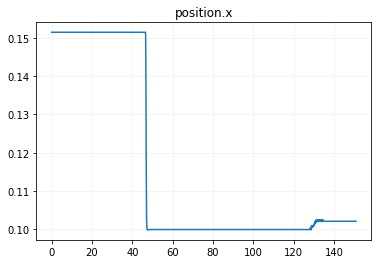

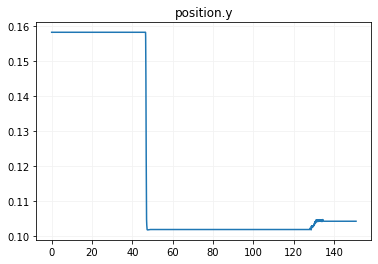

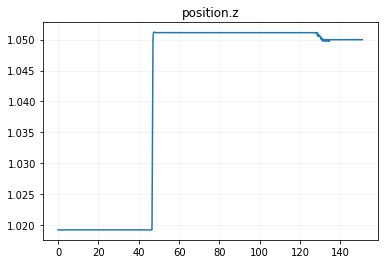

AssertionError: Please check one of your series from series list

<Figure size 360x360 with 0 Axes>

In [17]:
# Plot delta_twist_cmds 

show = False
# Plot cmd for tool speed
if show: 
    
    plot_series(delta_twist_cmds["Time"], delta_twist_cmds['twist.linear.x'], True)
    plot_series(delta_twist_cmds["Time"], delta_twist_cmds['twist.linear.y'], True)
    plot_series(delta_twist_cmds["Time"], delta_twist_cmds['twist.linear.z'], True)
    plot_series(delta_twist_cmds["Time"], delta_twist_cmds['twist.angular.x'], True)
    plot_series(delta_twist_cmds["Time"], delta_twist_cmds['twist.angular.y'], True)
    plot_series(delta_twist_cmds["Time"], delta_twist_cmds['twist.angular.z'], True)


    # Plot target pose from action server 
    plot_series(target_pose["Time"], target_pose['pose.position.x'], True)
    plot_series(target_pose["Time"], target_pose['pose.position.y'], True)
    plot_series(target_pose["Time"], target_pose['pose.position.z'], True)
    
#print(current_pose)
plot_series(current_pose["Time"], current_pose['position.x'], True)
plot_series(current_pose["Time"], current_pose['position.y'], True)
plot_series(current_pose["Time"], current_pose['position.z'], True)

config_dict = {
               "title":"Joint position", 
               "x_label":"t [s]",
               "y_label": "position [rad]",
               "w": 15,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }

plot_multiple_series(target_pose["Time"], target_pose)

In [18]:
bag_name = "magnetic9.bag"

b = bagreader(bag_name)
csv_files = []


for topic in b.topics:
    data = b.message_by_topic(topic)
    csv_files.append(data)

[INFO]  Data folder magnetic9 already exists. Not creating.


In [19]:
print(csv_files)

tool_current_pose = pd.read_csv(csv_files[0])
imu1_data = pd.read_csv(csv_files[1])
imu1_mag = pd.read_csv(csv_files[2])
imu2_data = pd.read_csv(csv_files[3])
imu2_mag = pd.read_csv(csv_files[4])
imu3_data = pd.read_csv(csv_files[5])
imu3_mag = pd.read_csv(csv_files[6])
servo_cmds = pd.read_csv(csv_files[7])
joint_states = pd.read_csv(csv_files[8])
magnetic_estimation = pd.read_csv(csv_files[9])
pose_error = pd.read_csv(csv_files[10])
ee_velocity = pd.read_csv(csv_files[11])
servo_status = pd.read_csv(csv_files[12])
target_pose = pd.read_csv(csv_files[13])

['magnetic9/control_arm_node-tool-current_pose.csv', 'magnetic9/imu1-data.csv', 'magnetic9/imu1-mag.csv', 'magnetic9/imu2-data.csv', 'magnetic9/imu2-mag.csv', 'magnetic9/imu3-data.csv', 'magnetic9/imu3-mag.csv', 'magnetic9/lwa4p-joint_group_position_controller-command.csv', 'magnetic9/lwa4p-joint_states.csv', 'magnetic9/magnetic_estimation.csv', 'magnetic9/move_group-goal.csv', 'magnetic9/pose_error.csv', 'magnetic9/servo_server-delta_twist_cmds.csv', 'magnetic9/servo_server-status.csv', 'magnetic9/servo_server-target_pose.csv']


22.260422229766846


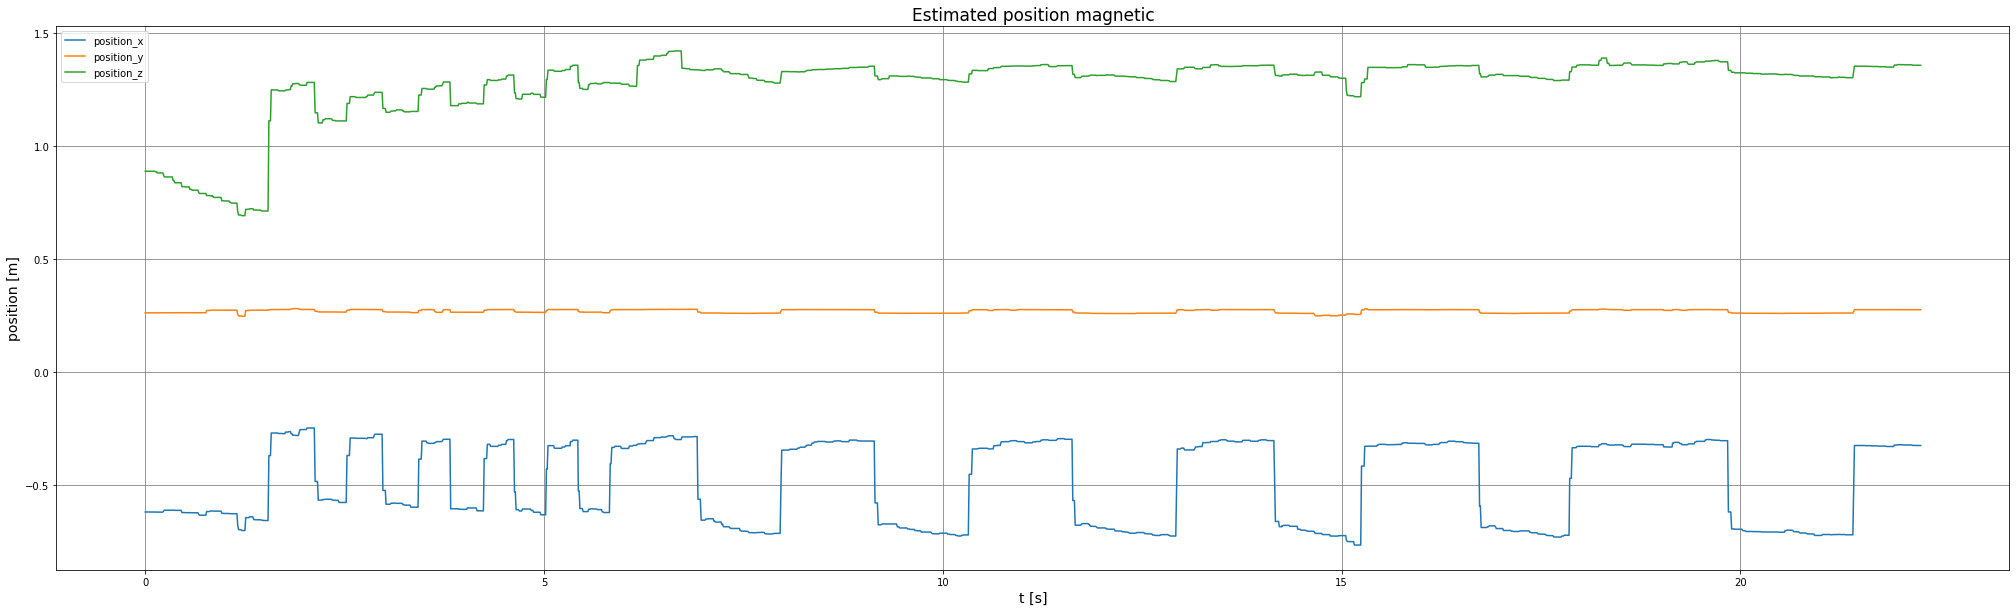

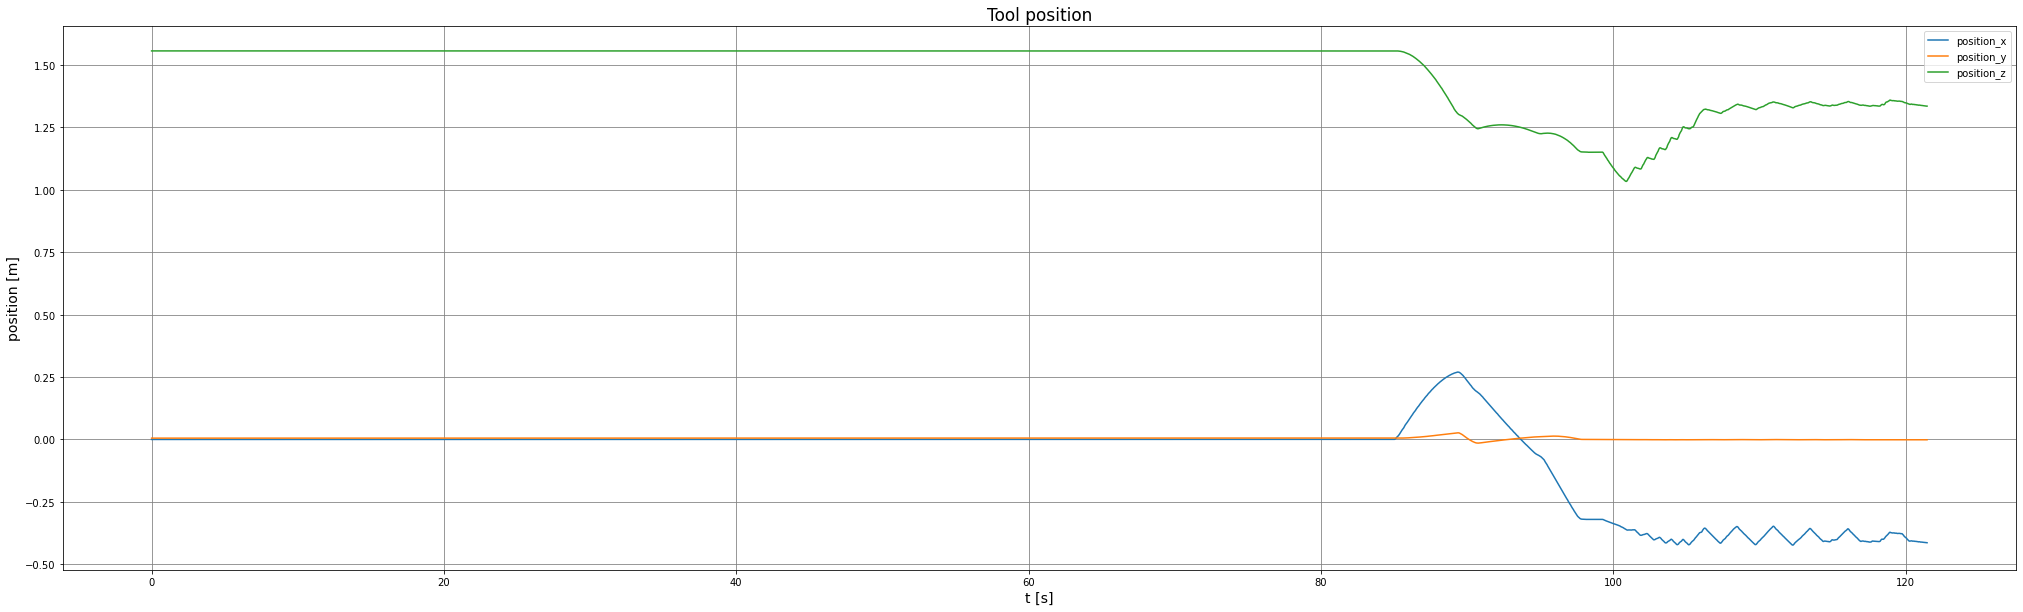

In [20]:
#plot_series(magnetic_estimation['Time'], magnetic_estimation['pose.position.x'])
#plot_multiple_series()

mag_series_list = get_series_by_key_from_df(magnetic_estimation, "position")
config_dict = {
               "title":"Estimated position magnetic", 
               "x_label":"t [s]",
               "y_label": "position [m]",
               "w": 35,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }


duration = get_duration(magnetic_estimation['Time'])
print(duration)


mag_est_names = ["position_x", "position_y", "position_z"]
plot_multiple_series(magnetic_estimation['Time'], mag_series_list,
                     mag_est_names, config_dict, scale_time=True,
                     save_fig=True, save_name="estimated_position1")

tool_pose_list = get_series_by_key_from_df(tool_current_pose, "position")
config_dict = {
               "title":"Tool position", 
               "x_label":"t [s]",
               "y_label": "position [m]",
               "w": 35,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }
tool_position_names = ["position_x", "position_y", "position_z"]
plot_multiple_series(tool_current_pose['Time'], tool_pose_list, 
                    tool_position_names, config_dict, scale_time=True, 
                    save_fig=True, save_name="arm_position1")


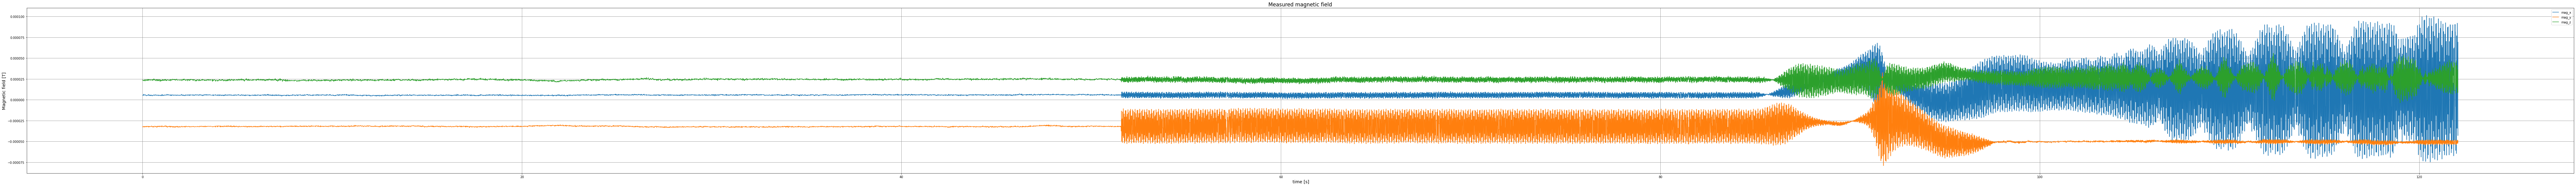

In [21]:
################################################################
################## IMU MAGNETIC FIELD ##########################
################################################################

imu_config_dict = {
               "title":"Measured magnetic field", 
               "x_label":" time [s]",
               "y_label": "Magnetic field [T]",
               "w": 150,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }


imu_mag_1 = get_series_by_key_from_df(imu1_mag, "magnetic_field")


mag_imu_names = ["mag_x", "mag_y", "mag_z"]
plot_multiple_series(imu1_mag['Time'], imu_mag_1,
                     mag_imu_names, imu_config_dict,
                     scale_time=True, save_fig=True, save_name="imu1")

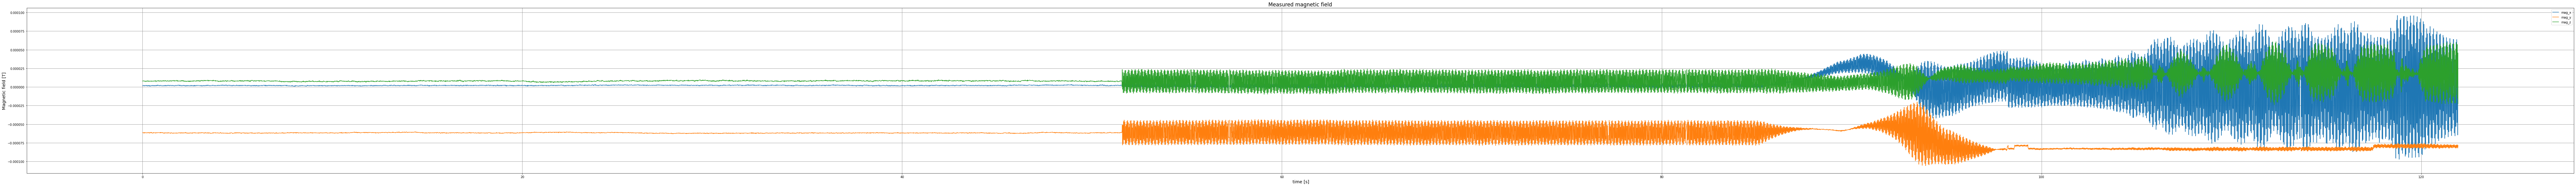

In [22]:
imu_mag_2 = get_series_by_key_from_df(imu2_mag, "magnetic_field")
plot_multiple_series(imu2_mag['Time'], imu_mag_2,
                     mag_imu_names, imu_config_dict,
                     scale_time=True, save_fig=True, save_name="imu2")


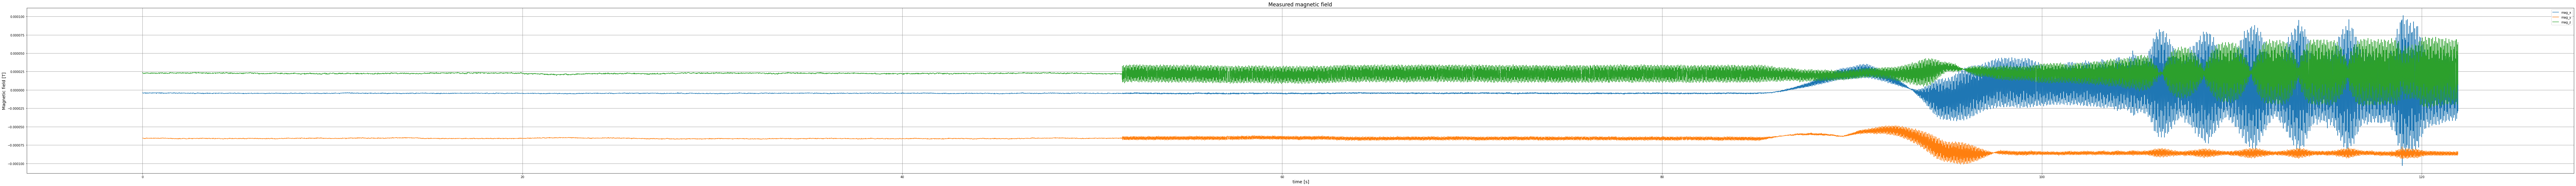

In [23]:
imu_mag_3 = get_series_by_key_from_df(imu3_mag, "magnetic_field")
plot_multiple_series(imu3_mag['Time'], imu_mag_3,
                     mag_imu_names, imu_config_dict,
                     scale_time=True, save_fig=True, save_name="imu3")

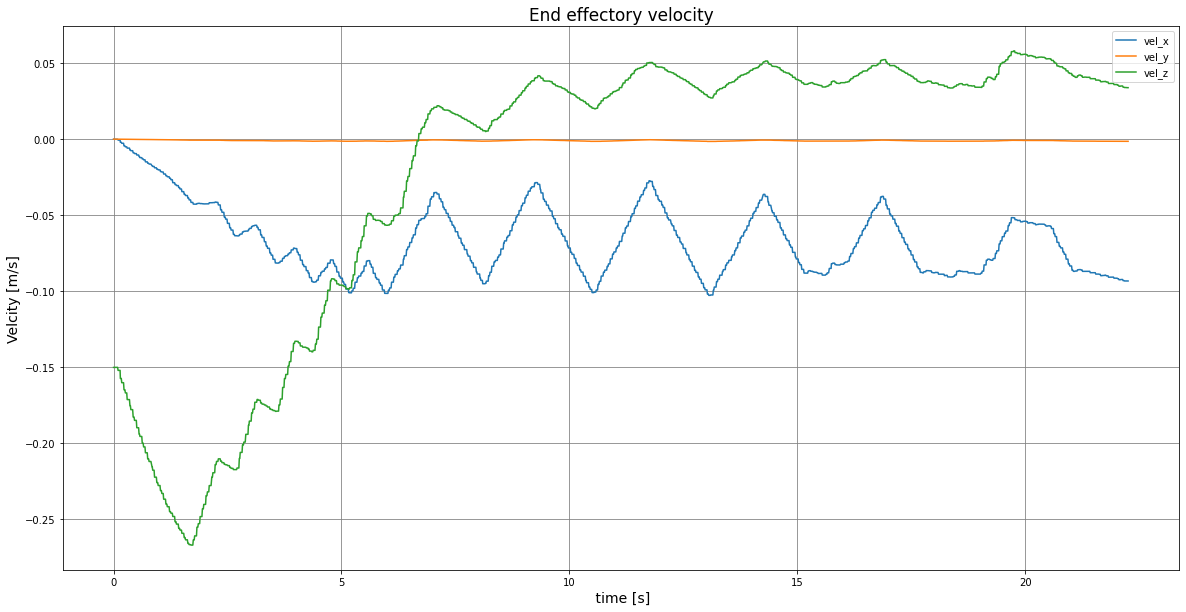

In [24]:
ee_velocity_list = [ee_velocity['x'], ee_velocity['y'], ee_velocity['z']]
ee_names = ['vel_x', 'vel_y', 'vel_z']

ee_config_dict = {
               "title":"End effectory velocity", 
               "x_label":" time [s]",
               "y_label": "Velcity [m/s]",
               "w": 20,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }

plot_multiple_series(ee_velocity['Time'], ee_velocity_list, 
                     ee_names, ee_config_dict, scale_time=True)

              Time  position.x  position.y  position.z  orientation.x  \
0     1.632834e+09   -0.000045    0.005262    1.555000      -0.000079   
1     1.632834e+09   -0.000045    0.005262    1.555000      -0.000079   
2     1.632834e+09   -0.000045    0.005262    1.555000      -0.000079   
3     1.632834e+09   -0.000045    0.005262    1.555000      -0.000079   
4     1.632834e+09   -0.000045    0.005262    1.555000      -0.000079   
...            ...         ...         ...         ...            ...   
3009  1.632834e+09   -0.412353   -0.001329    1.335088      -0.059879   
3010  1.632834e+09   -0.413083   -0.001341    1.334303      -0.060592   
3011  1.632834e+09   -0.413312   -0.001344    1.334081      -0.060780   
3012  1.632834e+09   -0.413335   -0.001345    1.333984      -0.060907   
3013  1.632834e+09   -0.413324   -0.001345    1.333988      -0.060907   

      orientation.y  orientation.z  orientation.w  
0     -4.690434e-07       0.999983       0.005877  
1     -4.690434e-07

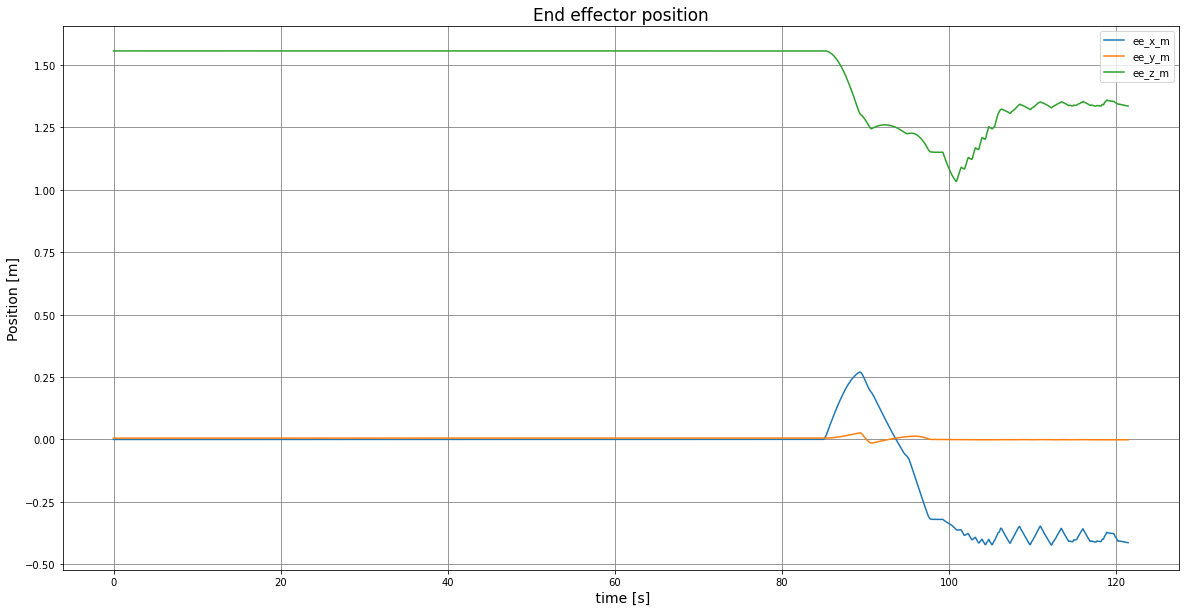

In [25]:
print(tool_current_pose)
arm_current_position_list = [tool_current_pose['position.x'], tool_current_pose['position.y'], tool_current_pose['position.z']]
arm_current_position_names = ['ee_x_m', 'ee_y_m', 'ee_z_m']

arm_pos_dict = {
               "title":"End effector position", 
               "x_label":" time [s]",
               "y_label": "Position [m]",
               "w": 20,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }

plot_multiple_series(tool_current_pose['Time'], arm_current_position_list,
                     arm_current_position_names, arm_pos_dict, scale_time=True)